In [2]:
import matplotlib.pyplot as plt 
import xarray as xr
import numpy as np

In [3]:
import momlevel as ml

In [4]:
import cmocean

In [5]:
import cartopy.crs as ccrs

In [6]:
# The following function is used to create weights for the Earths grid space.
import warnings 

def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

### Load in a Dataset of observed monthly-mean SST from OISST that contains data from January 1993 to Dec 2022. We also load in our land-sea mask for the dataset to be used later in a global mean calculation.

In [7]:
## Load a dataset of SST from OISST and assign to a variable called SST_OISST:
SST_OISST = xr.open_dataset('/home/ees_student/Unit5_Holtzman/data/sst.oisst.mon.mean.1993_2022.nc',
                           use_cftime=True)
                           ### this use_cftime=True allows Xarray to interpret time coords as calendar.

## load in a dataset that contains a land-sea mask:
OISST_landsea_mask = xr.open_dataset('/home/ees_student/Unit5_Holtzman/data/lsmask.nc')

### Compute and produce a timeseries of the following and describe your observations:
* ### area-weighted global average SST
* ### area-weighted arctic SST (55N to 90N)
* ### area-weighted antarctic SST (55S to 90S)

In [8]:
SST_monthly = SST_OISST.sst
SST_annual = ml.util.annual_average(SST_monthly,tcoord='time')

In [9]:
SST_avg= SST_annual.mean('lat').mean('lon')

<xarray.DataArray 'sst' (time: 30)>
array([13.17992098, 13.18050224, 13.24162729, 13.15880395, 13.27905443,
       13.34399416, 13.19437514, 13.22676812, 13.33048905, 13.33959662,
       13.38873532, 13.33426142, 13.42872706, 13.40824842, 13.39129908,
       13.35453716, 13.4109402 , 13.43738776, 13.37025992, 13.44180054,
       13.4476593 , 13.51502678, 13.58906853, 13.63042599, 13.57128028,
       13.52409044, 13.57643804, 13.63226196, 13.56569729, 13.6113145 ])
Coordinates:
  * time     (time) object 1993-07-02 12:00:00 ... 2022-07-02 12:00:00

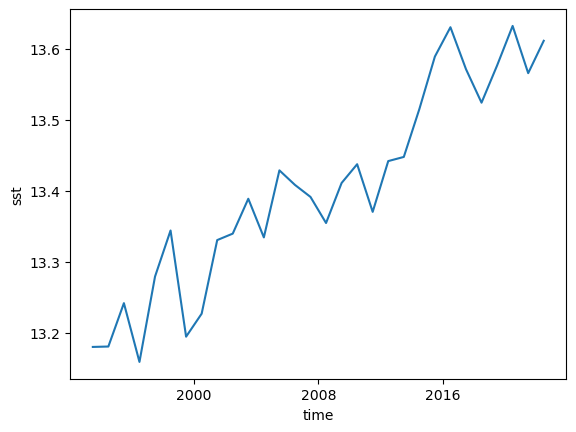

In [10]:
SST_avg.plot() #non-area weighted and unmasked global avg SST

Text(0.5, 1.0, 'Area-Weighted Global Average SST')

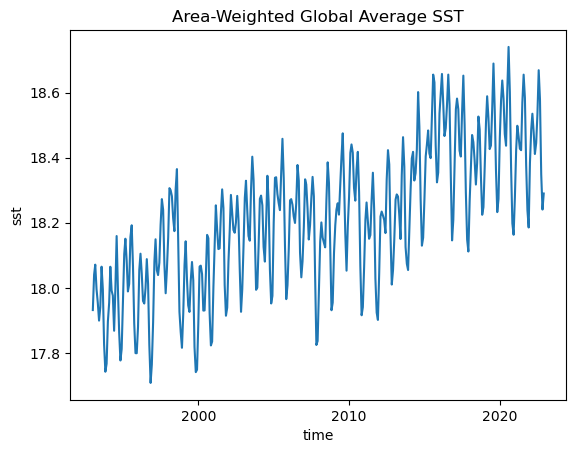

In [11]:
lat_sst = SST_OISST.coords['lat'].values 
lon_sst = SST_OISST.coords['lon'].values
areacell = standard_grid_cell_area(lat_sst,lon_sst)  
areacell_xarray = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(SST_OISST.coords['lat'],\
                                                        SST_OISST.coords['lon']))
weights = areacell_xarray*OISST_landsea_mask.mask
weighted_average_SST = SST_monthly.weighted(weights).mean(['lat', 'lon']) 
weighted_average_SST.plot() #area weighted global avg sst
plt.title('Area-Weighted Global Average SST')

Text(0.5, 1.0, 'Area-Weighted Arctic SST')

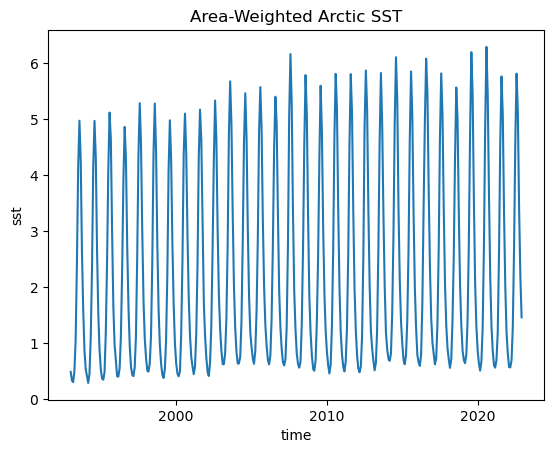

In [12]:
weights_arctic=weights.sel(lat=slice(55,90))
SST_arctic=SST_monthly.sel(lat=slice(55,90))
weighted_arctic_SST= SST_arctic.weighted(weights_arctic).mean(['lat','lon'])
weighted_arctic_SST.plot()
plt.title('Area-Weighted Arctic SST')

Text(0.5, 1.0, 'Area-Weighted Antarctic SST')

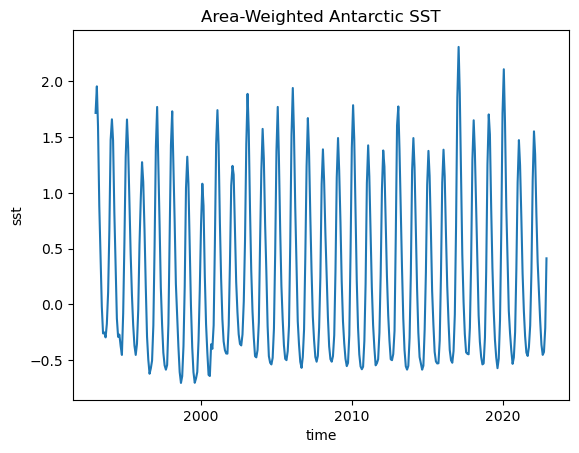

In [13]:
weights_antarctic=weights.sel(lat=slice(-90,-55))
SST_antarctic=SST_monthly.sel(lat=slice(-90,-55))
weighted_antarctic_SST= SST_antarctic.weighted(weights_antarctic).mean(['lat','lon'])
weighted_antarctic_SST.plot()
plt.title('Area-Weighted Antarctic SST')

### Produce a figure with 4 subplots that shows the global seasonal time-averaged (1993 to 2022) SST.

In [14]:
SST_seasonal=SST_monthly.groupby('time.season').mean(dim='time')
winter=SST_seasonal.sel(season='DJF')
spring=SST_seasonal.sel(season='MAM')
summer=SST_seasonal.sel(season='JJA')
fall=SST_seasonal.sel(season='SON')

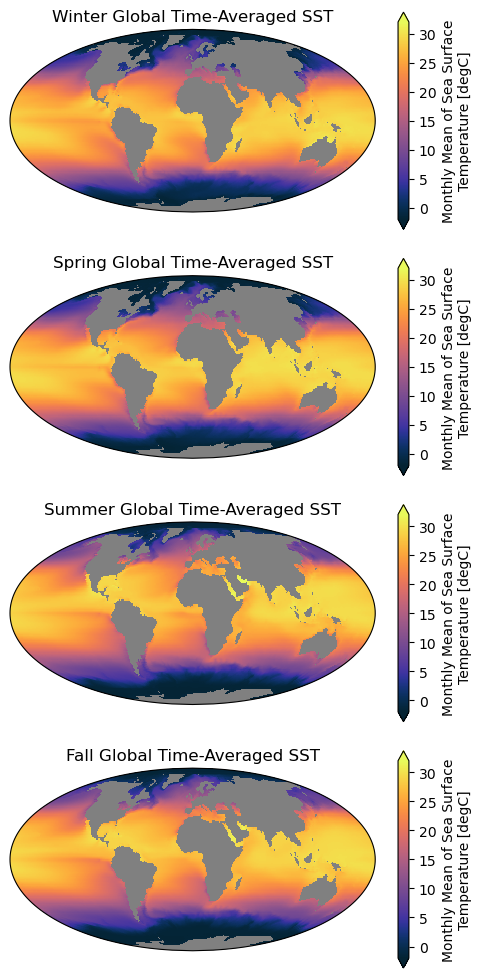

In [15]:
subplot_kws=dict(projection=ccrs.Mollweide(),
                 facecolor='grey')

fig, (ax1, ax2, ax3, ax4)=plt.subplots(ncols=1,nrows=4, figsize=(5,10),subplot_kw=subplot_kws)
winter.plot(ax=ax1, cmap=cmocean.cm.thermal, vmin=-2,vmax=32, 
            extend='both',transform=ccrs.PlateCarree())
spring.plot(ax=ax2, cmap=cmocean.cm.thermal, vmin=-2,vmax=32, 
            extend='both',transform=ccrs.PlateCarree())
summer.plot(ax=ax3, cmap=cmocean.cm.thermal, vmin=-2,vmax=32, 
            extend='both',transform=ccrs.PlateCarree())
fall.plot(ax=ax4, cmap=cmocean.cm.thermal, vmin=-2,vmax=32, 
          extend='both',transform=ccrs.PlateCarree())

ax1.set_title('Winter Global Time-Averaged SST')
ax2.set_title('Spring Global Time-Averaged SST')
ax3.set_title('Summer Global Time-Averaged SST')
ax4.set_title('Fall Global Time-Averaged SST')

plt.tight_layout()

### Produce a visualization of the average of the most recent 5 year average minus the first 5 years and describe the spatial patterns observed.

In [16]:
SST_lastfive=SST_monthly.sel(time=slice('2018-01-01','2022-12-31'))
SST_firstfive=SST_monthly.sel(time=slice('1993-01-01','1998-12-31'))

In [17]:
SST_lastfive_avg=SST_lastfive.mean(dim='time')
SST_firstfive_avg=SST_firstfive.mean(dim='time')

In [18]:
difference=SST_lastfive_avg-SST_firstfive_avg

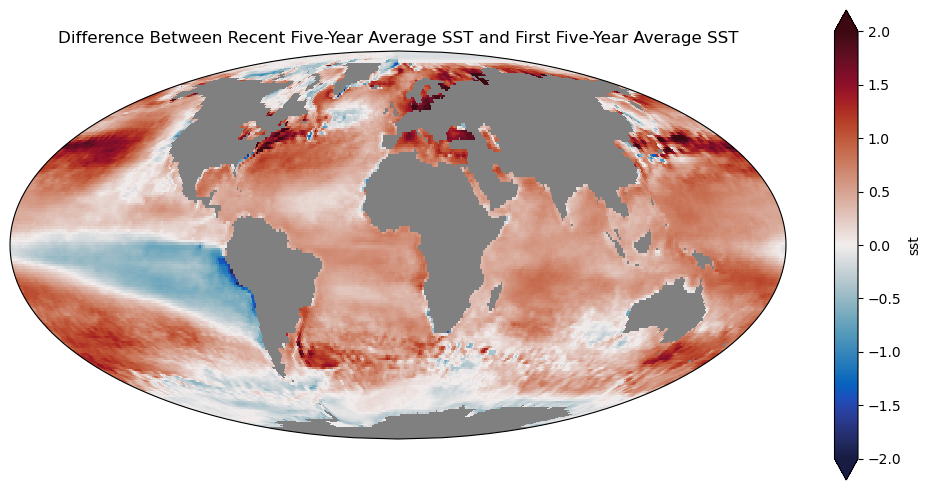

In [19]:
subplot_kws=dict(projection=ccrs.Mollweide(),
                 facecolor='grey')

fig, (ax)=plt.subplots(ncols=1,nrows=1, figsize=(10,5),subplot_kw=subplot_kws)
difference.plot(ax=ax, cmap=cmocean.cm.balance, vmin=-2,vmax=2, 
                extend='both',transform=ccrs.PlateCarree())

ax.set_title('Difference Between Recent Five-Year Average SST and First Five-Year Average SST')
plt.tight_layout()

### Repeat the analysis above but considering the seasonal differences.

In [20]:
lastfive_seasonal=SST_lastfive.groupby('time.season').mean(dim='time')
winter_lf=lastfive_seasonal.sel(season='DJF')
spring_lf=lastfive_seasonal.sel(season='MAM')
summer_lf=lastfive_seasonal.sel(season='JJA')
fall_lf=lastfive_seasonal.sel(season='SON')

firstfive_seasonal=SST_firstfive.groupby('time.season').mean(dim='time')
winter_ff=firstfive_seasonal.sel(season='DJF')
spring_ff=firstfive_seasonal.sel(season='MAM')
summer_ff=firstfive_seasonal.sel(season='JJA')
fall_ff=firstfive_seasonal.sel(season='SON')

In [21]:
winter_diff=winter_lf-winter_ff
spring_diff=spring_lf-spring_ff
summer_diff=summer_lf-summer_ff
fall_diff=fall_lf-fall_ff

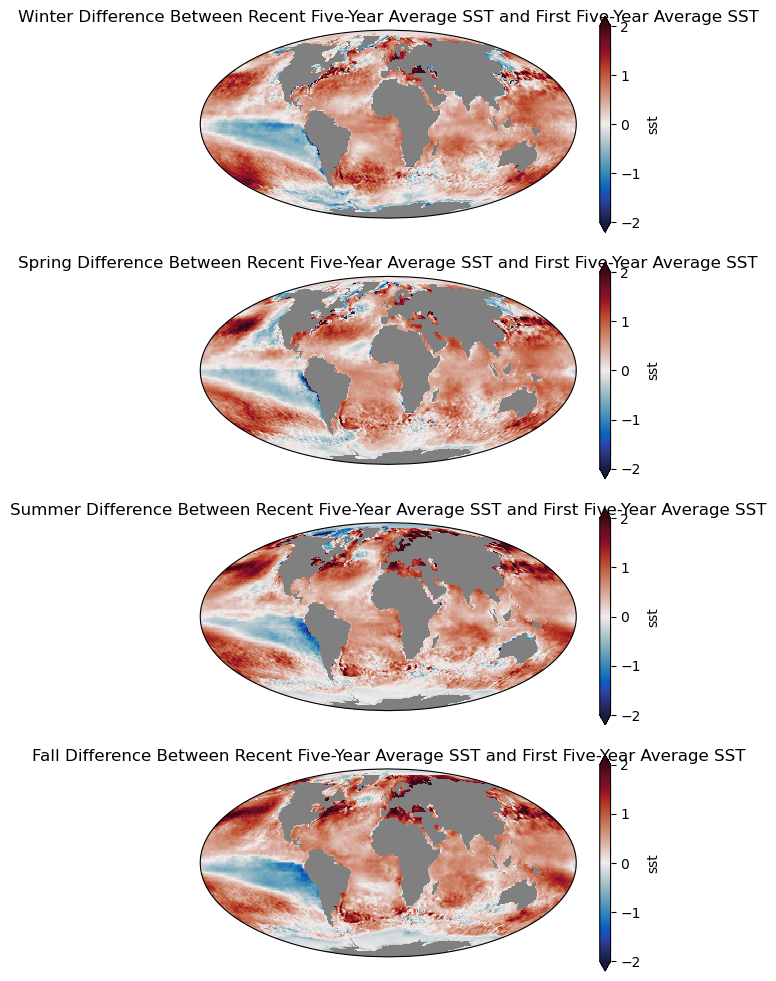

In [22]:
subplot_kws=dict(projection=ccrs.Mollweide(),
                 facecolor='grey')

fig, (ax1, ax2, ax3, ax4)=plt.subplots(ncols=1,nrows=4, figsize=(5,10),subplot_kw=subplot_kws)
winter_diff.plot(ax=ax1, cmap=cmocean.cm.balance, vmin=-2,vmax=2, 
                 extend='both',transform=ccrs.PlateCarree())
spring_diff.plot(ax=ax2, cmap=cmocean.cm.balance, vmin=-2,vmax=2, 
                 extend='both',transform=ccrs.PlateCarree())
summer_diff.plot(ax=ax3, cmap=cmocean.cm.balance, vmin=-2,vmax=2, 
                 extend='both',transform=ccrs.PlateCarree())
fall_diff.plot(ax=ax4, cmap=cmocean.cm.balance, vmin=-2,vmax=2, 
               extend='both',transform=ccrs.PlateCarree())

ax1.set_title('Winter Difference Between Recent Five-Year Average SST and First Five-Year Average SST')
ax2.set_title('Spring Difference Between Recent Five-Year Average SST and First Five-Year Average SST')
ax3.set_title('Summer Difference Between Recent Five-Year Average SST and First Five-Year Average SST')
ax4.set_title('Fall Difference Between Recent Five-Year Average SST and First Five-Year Average SST')

plt.tight_layout()

### Assess the annual - mean SST anomalies in 2022 compared to the 1993 to 2022 climatological average. What patterns stand out in 2022? 

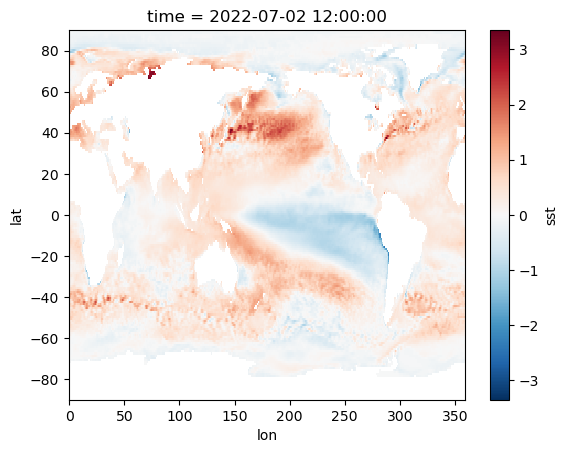

In [23]:
SST_2022= SST_annual.sel(time='2022-07-02')
SST_climatology=ml.util.annual_cycle(SST_monthly, tcoord='time')
climatology_mean=SST_climatology.mean(dim='time')
difference= SST_2022-climatology_mean
difference.plot()